First, the required libraries such as requests, BeautifulSoup, pandas, and regular expressions are set up. Then, data is collected from the Wikipedia page "List of countries by GDP (nominal)" and extracted the table's column headers. Afterward, cell data is extracted and cleaned up. With this clean data,'gdp_dataframe' in Pandas is created.Lastly, rows labeled "World" are excluded in the 'Country/Territory' column to focus on individual countries' GDP data.

In [154]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

page = requests.get("https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)")
soup = BeautifulSoup(page.content, "html.parser")

gdp_data = []

table = soup.find("table", {"class": "wikitable"})
rows = table.find_all("tr")

column_headers = [header.text.strip() for header in table.find_all("th")]

for row in rows:
    cells = row.find_all("td")
    row_data = {}
    cell_texts = [cell.text.strip() for cell in cells]

    for i in range(min(len(column_headers), len(cell_texts))):
        cell_text = re.sub(r'\[.*\]', '', cell_texts[i])
        row_data[column_headers[i]] = cell_text.strip()

        if column_headers[i] != "":
            row_data[column_headers[i]] = row_data[column_headers[i]].replace(',', '')

    gdp_data.append(row_data)

gdp_dataframe = pd.DataFrame(gdp_data)
gdp_dataframe = gdp_dataframe.dropna()

gdp_dataframe = gdp_dataframe.rename(columns={
    'IMF[1][13]': 'IMF Forecast',
    'World Bank[14]': 'IMF Year',
    'United Nations[15]': 'World Bank Estimate',
    'Forecast': 'World Bank Year',
    'Year': 'United Nations Estimate',
    'Estimate': 'United Nations Year',
})
gdp_dataframe = gdp_dataframe[~gdp_dataframe['Country/Territory'].str.contains('World')]

gdp_dataframe

,Country/Territory,UN region,IMF Forecast,IMF Year,World Bank Estimate,World Bank Year,United Nations Estimate,United Nations Year
3,United States,Americas,26949643,2023,25462700,2022,23315081,2021
4,China,Asia,17700899,2023,17963171,2022,17734131,2021
5,Germany,Europe,4429838,2023,4072192,2022,4259935,2021
6,Japan,Asia,4230862,2023,4231141,2022,4940878,2021
7,India,Asia,3732224,2023,3385090,2022,3201471,2021
...,...,...,...,...,...,...,...,...
207,Micronesia,Oceania,458,2023,427,2022,404,2021
208,Marshall Islands,Oceania,277,2023,280,2022,257,2021
212,Kiribati,Oceania,246,2023,223,2022,227,2021
213,Nauru,Oceania,150,2023,151,2022,155,2021


A bar plot is created to display the top 10 countries by GDP according to IMF forecasts. The data is visualized using Matplotlib and Seaborn. United States has the highest GDP, followed by China and Germany.

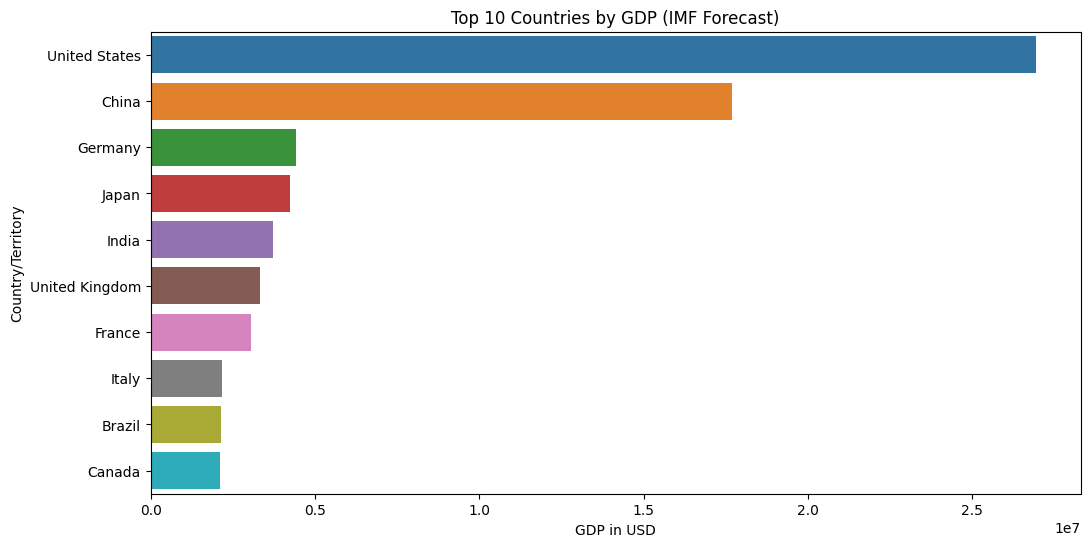

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

gdp_dataframe['IMF Forecast'] = gdp_dataframe['IMF Forecast'].str.replace(',', '').astype(float)

N = 10
top_N_countries = gdp_dataframe.head(N)
plt.figure(figsize=(12, 6))
sns.barplot(x='IMF Forecast', y='Country/Territory', data=top_N_countries)
plt.title(f'Top {N} Countries by GDP (IMF Forecast)')
plt.xlabel('GDP in USD')
plt.ylabel('Country/Territory')
plt.show()


The GDP is aggregated by UN region, and a bar plot is created to show the total GDP for each region. The plot reveals that Asia and the Americas have the highest GDP, followed by Europe, while other regions like Africa and Oceania have relatively lower GDP.

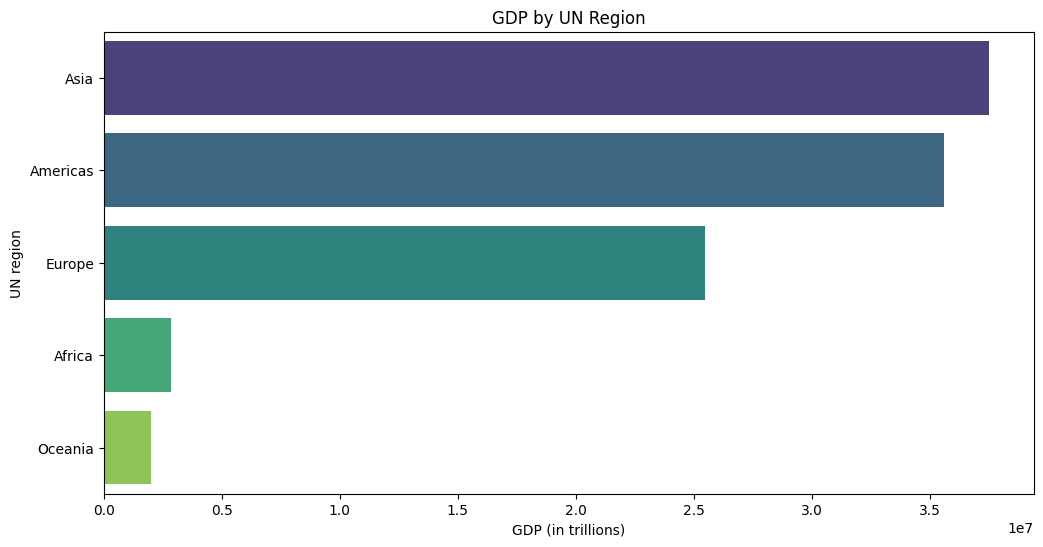

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

gdp_by_region = gdp_dataframe.groupby('UN region')['IMF Forecast'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=gdp_by_region.values, y=gdp_by_region.index, palette="viridis")
plt.xlabel('GDP (in trillions)')
plt.title('GDP by UN Region')
plt.show()


Line plots are created to display the GDP estimates over time for selected countries (United States, China, India, Japan, Germany). Data from the IMF, World Bank, and United Nations is shown on the same graph.

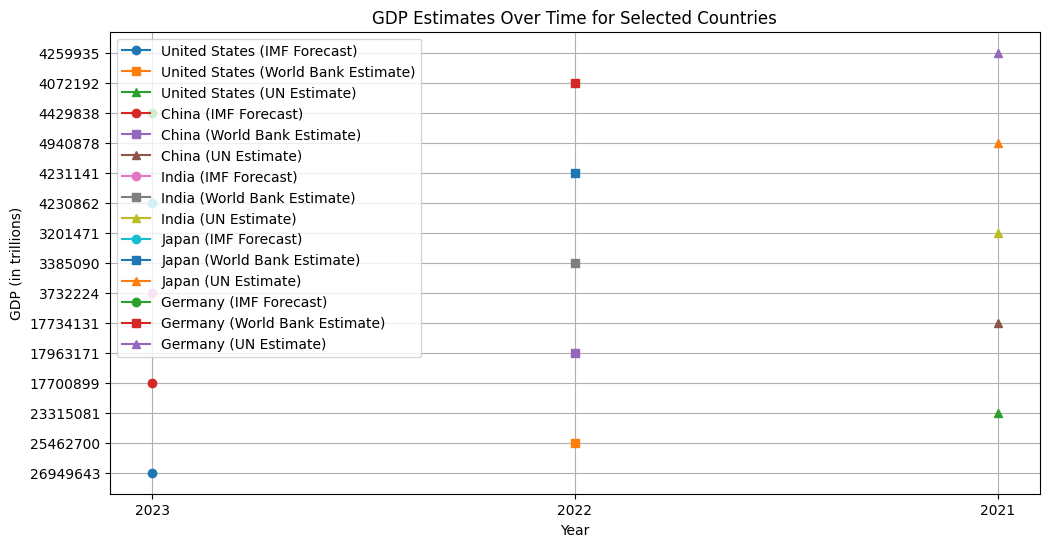

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

countries_to_plot = ['United States', 'China', 'India', 'Japan', 'Germany']

plt.figure(figsize=(12, 6))

for country_name in countries_to_plot:
    country_data = gdp_dataframe[gdp_dataframe['Country/Territory'] == country_name]
    plt.plot(country_data['IMF Year'], country_data['IMF Forecast'], label=f'{country_name} (IMF Forecast)', marker='o')
    plt.plot(country_data['World Bank Year'], country_data['World Bank Estimate'], label=f'{country_name} (World Bank Estimate)', marker='s')
    plt.plot(country_data['United Nations Year'], country_data['United Nations Estimate'], label=f'{country_name} (UN Estimate)', marker='^')

plt.xlabel('Year')
plt.ylabel('GDP (in trillions)')
plt.title('GDP Estimates Over Time for Selected Countries')
plt.legend()
plt.grid()
plt.show()




Line plots show the trends of GDP over the years, displaying the mean GDP estimates for all countries. It shows that the projected mean GDP has steadily increased from 2021 to 2023.

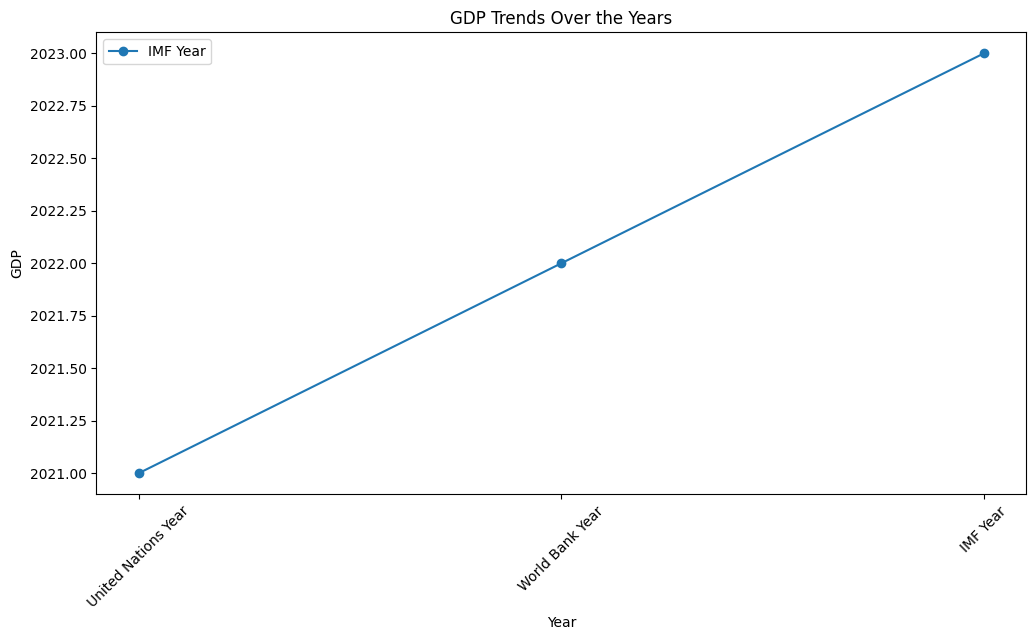

In [151]:
import matplotlib.pyplot as plt

gdp_trends = gdp_dataframe[['IMF Year', 'World Bank Year', 'United Nations Year']]
gdp_trends = gdp_trends.apply(pd.to_numeric, errors='coerce')  # Convert to numeric

plt.figure(figsize=(12, 6))
plt.plot(gdp_trends.mean(), marker='o')
plt.title('GDP Trends Over the Years')
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend(gdp_trends.columns)

plt.gca().invert_xaxis()

plt.show()
